# __DFN generation from multiple fracture domains__


### Problem statement

The modeling of a particular site may require the definition of several geological domains with different fracture properties. DFN.lab supports sub-domains by splitting the model volume into sub-domains with different properties.

<center>
<div>
<img src="https://gitlab.com/fractorylab/dfnlab/-/raw/master/Tutorials/img/siteModelling.PNG" width="800"/>
</div>
<br>
Fracture domain decomposition and corresponding stochastic DFN
</center>

### What will you learn ?

* Divide the model volume into several sub-domains with an octree-based representation
* Adapt the DFN generator to this sub-domain description



### DFN.Lab model

A sub-domain is described either as a closed volume (named _Fracture domain_) or from a surface of given width (named _Deformation zone_).

We assume that the reader is familiar with [domains](002-Domain.ipynb) and [DFN stochastic generation](006-Stochastic_DFN_generation.ipynb) concepts.


## Example 1: DFN generation from multiple fracture domains

In [1]:
import dfnlab.Geometry as dfn_geo
import dfnlab.System as dfn_sys
import dfnlab.Fractures as dfn_fra
import dfnlab.Domains as dfn_dom
import dfnlab.Generator as dfn_gen

First we define a system made up of an empty DFN and a model volume (here a cube of size $L=20$).
The global domain is not mandatory and can be empty but it can help to define the volume of investigation. If not provided, DFN.lab will build an internal global domain as the parallelepiped enclosing all subdomains.

In [2]:
system = dfn_sys.System()
domain = dfn_dom.Domain()
domain.buildParallelepiped([0, 0, 0], L1=20.)  
fnet = dfn_fra.DFN()
system.setDFN(fnet)
system.setDomain(domain)

#### Decomposition of the domain into sub-domains

Here we divide the general domain into two fracture domains. <br>
The domains are defined from surfaces defining a closed volume and loaded from STL files. <br>
We first load the STL files.

In [3]:
stlReaders = []
stlFileList=["./sources/STL-Example/domain1.stl","./sources/STL-Example/domain2.stl"]
for stlFile in stlFileList:   
    reader = dfn_geo.STLReader(stlFile)
    stlReaders.append(reader)

Then, we create fracture domains and add them to the global domain.

In [4]:
for reader in stlReaders:
    fractureDomain = dfn_dom.FractureDomain(reader.getDomain())
    domain.addFractureDomain(fractureDomain)

In DFN.lab, the volumes are represented by an octree. The greater the depth of the octree, the greater the accuracy of the representation of the domain boundaries.<br>
The argument of the method is the depth of the tree.


In [5]:
domain.populateOctree(limit=5)

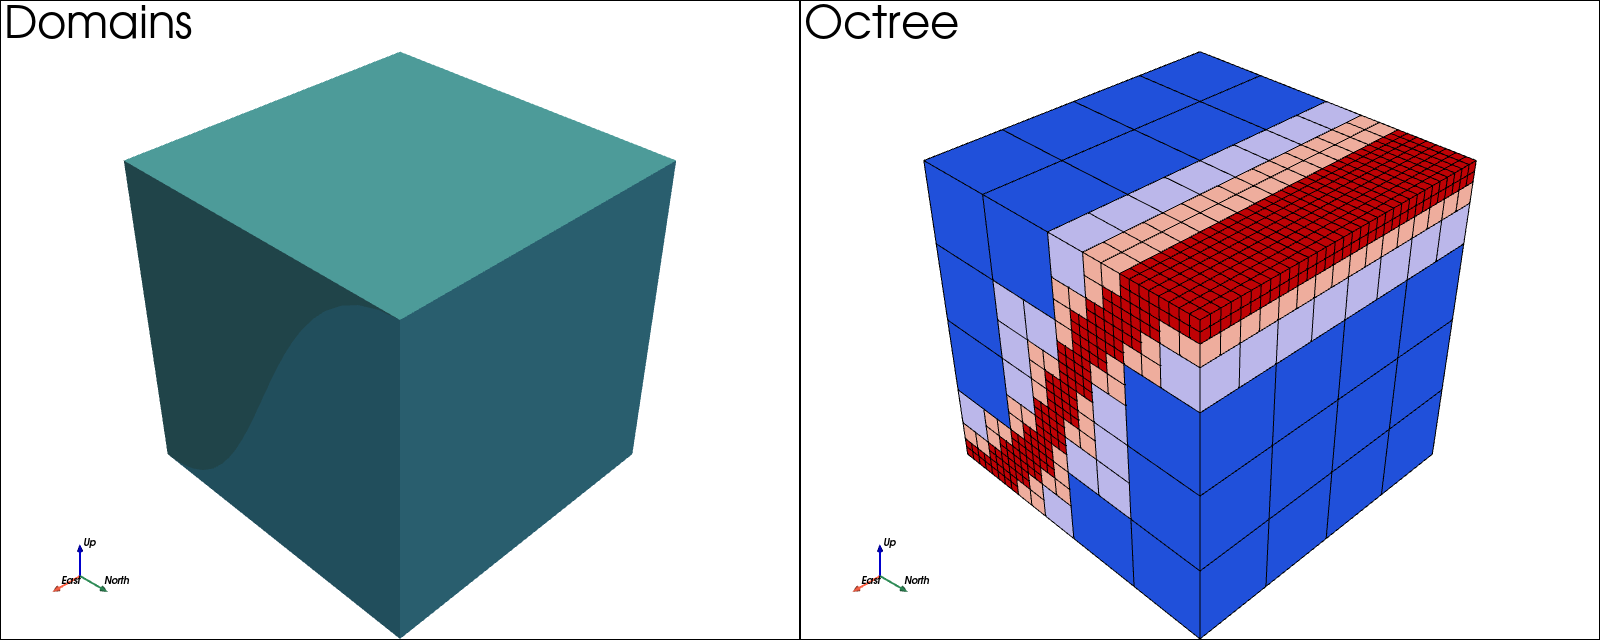

In [6]:
from sources.functions import plot_octree_and_domains
plot_octree_and_domains(domain,stlFileList)

#### DFN generation constrained by fracture domains

We here define stochastic fracture networks for the two sub-domains. "Domains 0" will be populated by two fracture sets whereas "Domain 1" will be populated by a single, low intensity, set.

In [7]:
prop1 = dfn_gen.Statistics()
prop1.setSizesPowerlaw(a=3,lmin=1,lmax=10)
prop1.setStopDensity(0.5)
prop1.setOrientationsFisher(dip=0.,dipd=0.,kappa=20.)
prop1.setPositionsUniform()

prop2 = dfn_gen.Statistics()
prop2.setSizesPowerlaw(a=3,lmin=0.5,lmax=5)
prop2.setStopDensity(0.3)
prop2.setOrientationsFisher(dip=90.,dipd=0.,kappa=20.)
prop2.setPositionsUniform()

prop3 = dfn_gen.Statistics()
prop3.setSizesPowerlaw(a=3,lmin=1,lmax=10)
prop3.setStopDensity(0.1)
prop3.setOrientationsFisher(dip=45.,dipd=0.,kappa=20.)
prop3.setPositionsUniform()

We first create an empty property object, add properties and then assign the properties to each domain using the keyword "generate".

In [8]:
#Domain 0 properties assigned
domainprop1 = dfn_gen.Properties()
domainprop1.add(prop1,"set1")
domainprop1.add(prop2,"set2")
domain.getFractureDomain(0).addProperties("generation",domainprop1)

# Domain 1 is populated with an alternative method for educative purposes.
domainprop2 = dfn_gen.Properties(prop3)
domain.getFractureDomain(1).addProperties("generation",domainprop2)

Everything is ready for the generation. <br>

In [9]:
generatorFracture = dfn_gen.Generator(system,seed=1001)
generatorFracture.generateByDomains();

To know the number of fractures and make the visualization, we first need to assemble all components of the system (build):

In [10]:
# Assemble the system
system.build()
import dfnlab.Analysis as analysis
analyser = analysis.Analyser(system)

# Display some statistics.
print("nf={}".format(fnet.numFractures()))
print("p32={}".format(analyser.p32()))

nf=1614
p32=0.4579900812001332


Visualize the generated DFNs. The top domain has a very high density compared to the bottom domain:

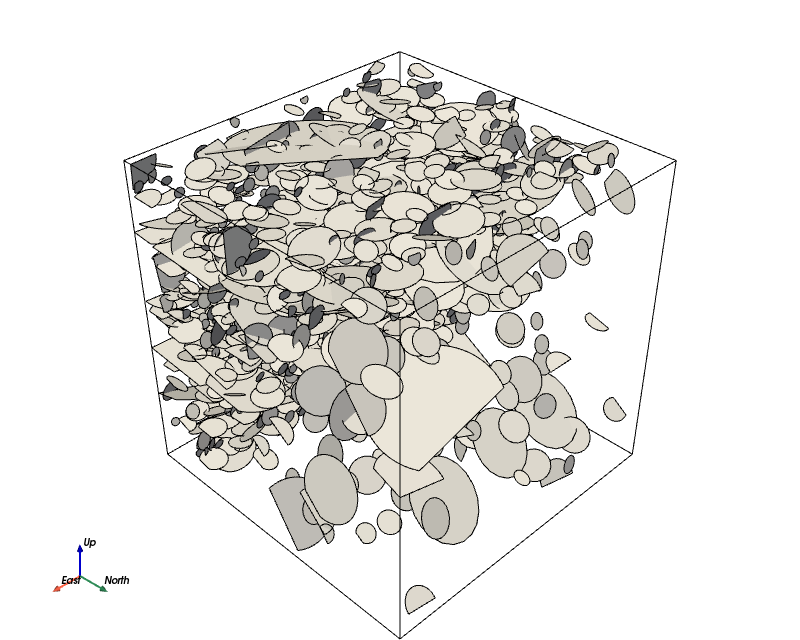

In [11]:
from sources.functions import plot_dfn
plot_dfn(system)

_____________

## Example 2: DFN in deformation zones

In this example, we will create the DFN same as in previous example but add a
deformation zone which we will populate with fractures.

In [12]:
system = dfn_sys.System()
domain = dfn_dom.Domain()
domain.buildParallelepiped([0, 0, 0], L1=20)  
system.setDomain(domain)
fnet = dfn_fra.DFN()
system.setDFN(fnet)

stlReaders = []
stlFileList=["./sources/STL-Example/domain1.stl","./sources/STL-Example/domain2.stl"]
for stlFile in stlFileList:   
    reader = dfn_geo.STLReader(stlFile)
    stlReaders.append(reader)
    
for reader in stlReaders:
    fractureDomain = dfn_dom.FractureDomain(reader.getDomain())
    domain.addFractureDomain(fractureDomain)
    
prop1 = dfn_gen.Statistics()
prop1.setSizesPowerlaw(a=3,lmin=1,lmax=10)
prop1.setStopDensity(0.5)
prop1.setOrientationsFisher(dip=0.,dipd=0.,kappa=20.)
prop1.setPositionsUniform()

prop2 = dfn_gen.Statistics()
prop2.setSizesPowerlaw(a=3,lmin=0.5,lmax=5)
prop2.setStopDensity(0.3)
prop2.setOrientationsFisher(dip=90.,dipd=0.,kappa=20.)
prop2.setPositionsUniform()

prop3 = dfn_gen.Statistics()
prop3.setSizesPowerlaw(a=3,lmin=1,lmax=10)
prop3.setStopDensity(0.1)
prop3.setOrientationsFisher(dip=45.,dipd=0.,kappa=20.)
prop3.setPositionsUniform()

domainprop1 = dfn_gen.Properties()
domainprop1.add(prop1,"set1")
domainprop1.add(prop2,"set2")
domain.getFractureDomain(0).addProperties("generation",domainprop1)

domainprop2 = dfn_gen.Properties(prop3)
domain.getFractureDomain(1).addProperties("generation",domainprop2)

Deformation zone's geometry is defined from a surface (loaded from a STL file) and a width of 4.

In [13]:
stlReader =dfn_geo.STLReader("sources/deformation_zone.stl") 
deformationZone = dfn_dom.DeformationZone(irregularSurface=stlReader.getSurface(),width=4)

The deformation zone must be attached to the global domain:

In [14]:
domain.addDeformationZone(deformationZone)

Now, we add generation properties to the deformationZone:

In [15]:
generationPropZone = dfn_gen.Statistics()
generationPropZone.setSizesUniform(lmin=1,lmax=2)
generationPropZone.setOrientationsUniform()
generationPropZone.setStopDensity(5)
generationPropZone.setPositionsUniform()

domainpropZone = dfn_gen.Properties(generationPropZone)
deformationZone.addProperties("generation",domainpropZone)

We can construct now construct an octree representation of the domain.

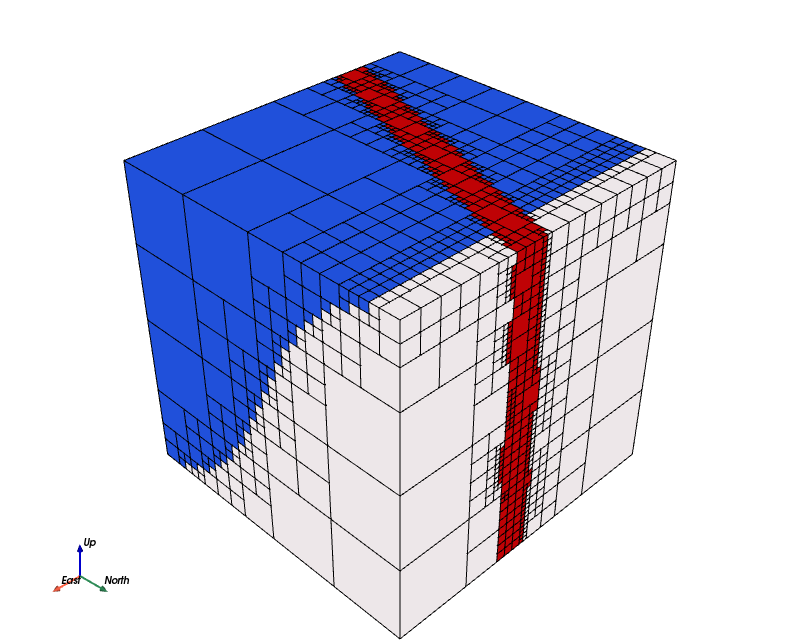

In [16]:
domain.populateOctree(limit=5)

from sources.functions import plot_octree
plot_octree(domain)

And perform the DFN generation.

In [17]:
generatorFracture = dfn_gen.Generator(system,seed=1001)
generatorFracture.generateByDomains()
system.build()

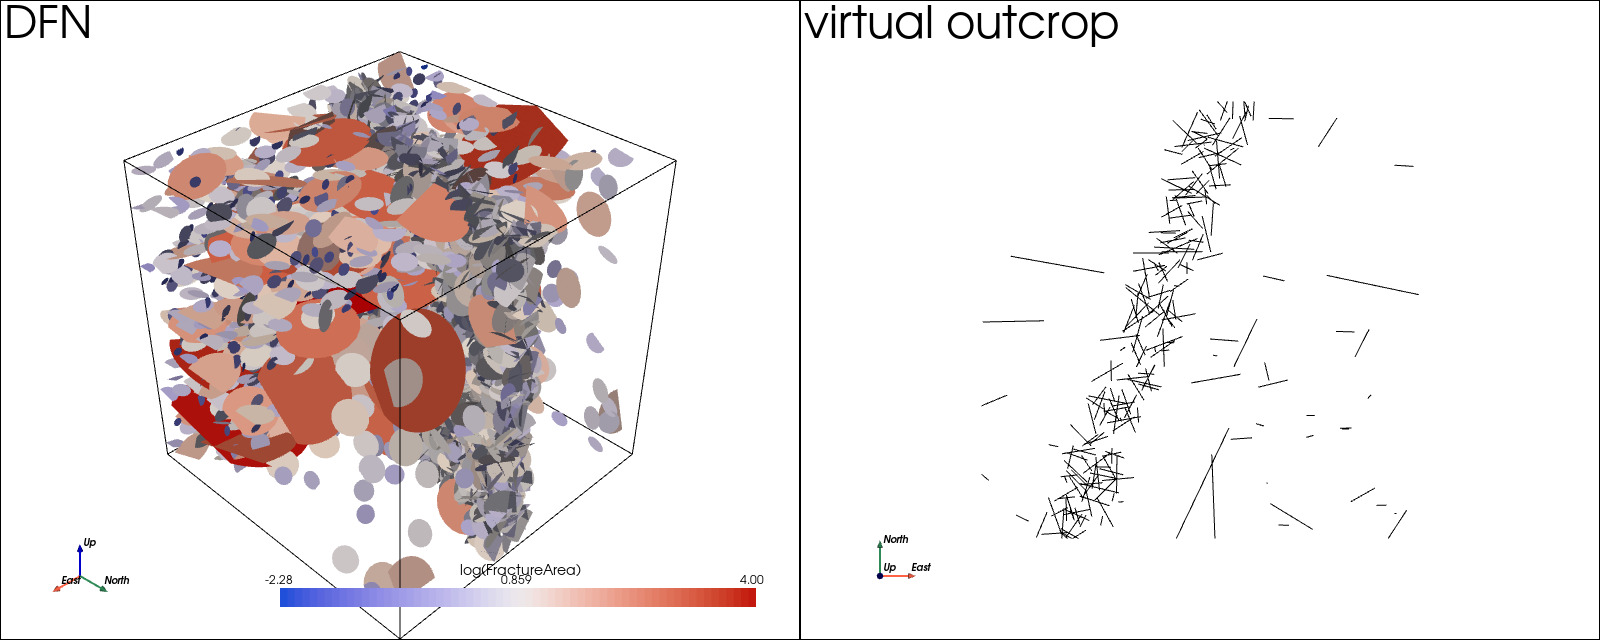

In [18]:
from sources.functions import plot_dfn_and_slice
plot_dfn_and_slice(system,"FractureArea",log=True,axis='z')